# Poiseuille Flow in a Square Channel

Tutorial adapted from Anders Logg and Hans Petter Langtangen 
More details on equation derivations and reference at   
https://jsdokken.com/dolfinx-tutorial/chapter2/navierstokes.html  

## Problem Definition

Fuid flow through a channel is known as Poiseuille flow, shown in the figure. In this case, the horizontal flow is driven by a pressure difference across the channel (left to right). The volocity profile of the flow is expected to be parabolic, with the maximum velocity at the center of the channel.

<img src="channelFlow.png" align="center">

$p_{inlet} = 8$  
$p_{outlet} = 0$  
$u_{walls} = 0$  
$ \rho = \mu = 1$  
$ f = 0$ (other body forces/sources)

## Navier Stokes Equation

The incompressible Naview Stoke equations is given as

$$\rho \left(\frac{\partial u}{\partial t}+u\cdot \nabla u \right) = \nabla \cdot \sigma (u, p) + f$$  
$$ \nabla\cdot u = 0$$  

Where $\rho$, u, t, \sigma, p, and f are the fluid density, velocity, time, stress tensor, pressure, and body forces (e.g. pressure), respectively. The first equation consdiers conservation of momentum, with the terms on the right hand side being the stress tensor and the body forces (e.g. pressure). The second equation is the continuity equation. The stress tensor for  Newtownan fluid depends on the strain rate tensor $\epsilon (u)$:  
$$\sigma (u,p)=2\mu\epsilon(u) - pI$$  
$$\epsilon (u) = \frac{1}{2}\left( \nabla u+(\nabla U)^T\right)$$

Where $\mu$ and I are the dynamic viscosity and the identity matrix, respectively. When solving for fluid flow, pressure and velocity are often quantities of interst; however, the equations for these variable are coupled and nonlinear, so an iterative solver is often used. This problem is solved using the Incremental Pressure Correction Scheme (IPCS), which is done in three steps:  
    1. Velocity prediction  
    2. Pressure  
    3. Pressure corrector  

These will be described in more detail below.

## Note on Superscripts

$X^n = $ value from previous time step  
$X^{n+\frac{1}{2}} = $ intermediate value  
$X^{n+1} = $ value from next timestep  
$X^* = $ predicted value  




## Import Step

In [2]:
# **** IMPORT *** #

from mpi4py import MPI  # for parallel
from petsc4py import PETSc # matrix solver library
import numpy as np # for array manipulation
import pyvista # visualization

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical # define constants and functions, boundary conditions, 
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc # assemble matrix equations, apply and enforce BC
from dolfinx.io import VTXWriter # write to VTX
from dolfinx.mesh import create_unit_square # create square mesh
from dolfinx.plot import vtk_mesh # plot VTK mesh
from basix.ufl import element # make elements
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, # face normal vector, identity matrix, test and trial functions
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym) # descirbe the variational form symbolically. math terms



## Create Mesh

In [3]:
# *** MESH *** #

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10) # create 10x10 element square
t = 0 # initial time
T = 10 # total simulation time
num_steps = 500 # number of timesteps
dt = T / num_steps # calculate timestep 


## Define Function Spaces and Trial Functions

In [4]:
# *** FUNCTION SPACE *** #

# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #
# one set for each function space

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)


## Set Boundary Conditions

In [5]:
# *** DEFINE BOUNDARY CONDITIONS *** #
# all are Dirichlet

# 1. WALLS - top and bottom, no slip BC
# work with V function space because we are setting velocity BC

def walls(x): # define where the walls are
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

wall_dofs = locate_dofs_geometrical(V, walls) # find the dofs on the walls
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0

# 2. INLET - high pressure driven frow from the left
# work with Q function space because we are setting pressure BC

def inflow(x): # define where the inlet is
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar

# 3. OUTLET - low pressure on the right to drive flow
# work with Q function space because we are setting pressure BC

def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]

## Define Constants and Other Variables

In [6]:
# *** DEFINE CONSTANTS/VARIABLES *** #

n = FacetNormal(mesh) # normal vector
# define parameters as constants (dolphinx function)
f = Constant(mesh, PETSc.ScalarType((0, 0))) # additional body forces (none here)
k = Constant(mesh, PETSc.ScalarType(dt)) # timestep
mu = Constant(mesh, PETSc.ScalarType(1)) # viscosity
rho = Constant(mesh, PETSc.ScalarType(1)) # density

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

## Set up Variational Forms  

Matrix equations defined and assembled. There are three steps to solving the incompressible Navier Stokes equations, so three matrix equations are defined. First is a velocity predictor step, a tentative velocity is found based on the pressure from the previous timestep and an intermediate velocity. The following equation is solved for $u^*$, the velocity predictor. $v$ is the test function in the velocity function space.

First step (Eq. 39):  
$$\left< \rho \frac{u^* - u^n}{\Delta t} \right> + \left< \rho u^n \cdot \nabla u^n,v \right> + \left< \sigma (u^{n+\frac{1}{2}},p^n),\epsilon (v) \right> + \left< p^nn,v\right>_{\partial \Omega} - \left<\mu \nabla u^{n+\frac{1}{2}}\cdot n,v\right>_{\partial \Omega} = \left< f^{n+1},v\right> $$   

The second step uses the predicted velocity to calcualte the pressure ($p^{n+1}$) with the equation below. $q$ is the test function in the pressure function space.

Second step (Eq. 40):   
$$ \left< \nabla p^{n+1},\nabla q\right> = \left< \nabla p^{n},\nabla q\right>- \frac{\rho}{\Delta t} \left< \nabla \cdot u^*,q\right>$$  

Finally, the updated pressure ($p^{n+1}$) and the predicted velocity ($u^*$) are used to calculate the new velocity ($u^{n+1}$).

Third Step (Eq. 42):  
$$\rho \left< \left( u^{n+1} - n^*\right),v\right>=-\Delta t\left<\nabla \left( p^{n+1}-p^n\right)\right>$$  

All matrix equations are of the form AX = b where A is the coefficients/operators, X is the quantity of interest, and b is the vector solution (RHS).

In [7]:
# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  # velocity form last time
u_n.name = "u_n" # name the variable
U = 0.5 * (u_n + u) # velocity predictor (u^{n+1/2})

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) # pressure from last step 
p_n.name = "p_n" # name variable
F1 = rho * dot((u - u_n) / k, v) * dx # first term eq. 39
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx # second term eq.39
F1 += inner(sigma(U, p_n), epsilon(v)) * dx # third term eq. 39
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds # fourth term eq 39
F1 -= dot(f, v) * dx # fifth term eq. 39
a1 = form(lhs(F1)) # a1 = LHS of eq. 39
L1 = form(rhs(F1)) # L1 = rhs of eq. 39

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) # assemble matrix for lhs of 39, note boundary conditions
A1.assemble() # assemble step
b1 = create_vector(L1) # rhs of equation to be solved

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) # u_ = velocity prediction (u*)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) # LHS of eq 40
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) # rhs of eq 40
A2 = assemble_matrix(a2, bcs=bcp) # assemble matrix with BC
A2.assemble() # assemble
b2 = create_vector(L2) # make vector for rhs
# A2*p = b2

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) # p_ = p from step 2
a3 = form(rho * dot(u, v) * dx) # lhs of (42)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) # rhs of (42)
A3 = assemble_matrix(a3) # assemble
A3.assemble() # assemble
b3 = create_vector(L3) # rhs vector
# A3 * U = b3


## Solver Set Up

Define a solver for each step in the solution and choose schemes and preconditioner.

In [8]:
# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) # create solver
solver1.setOperators(A1) # set A1 as operator in equation
solver1.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme (nonsymmetric)
pc1 = solver1.getPC() # get preconditioner
pc1.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc1.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) # create solver
solver2.setOperators(A2) # set A2 as operator
solver2.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme
pc2 = solver2.getPC() # get preconditioner
pc2.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc2.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) # create solver
solver3.setOperators(A3) # set A3 as operator
solver3.setType(PETSc.KSP.Type.CG) # use conjugate gradient scheme
pc3 = solver3.getPC() # get preconditioner
pc3.setType(PETSc.PC.Type.SOR) # use Gauss Seidel preconditioner


## Prepare Output Files

In [9]:
# *** OUTPUT FILES *** #

from pathlib import Path # for navigation
folder = Path("results") # define output directory as pwd/results
folder.mkdir(exist_ok=True, parents=True) # make the output directory and any recursive directories
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4") # make vtx file for velocity 
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4") # make vtx file for pressure
vtx_u.write(t) # write time to velocity file
vtx_p.write(t) # write time to pressure file

## Analytic Solution

In [10]:
# ** ANALYTIC SOLUTION *** #

def u_exact(x): # analytic solution function
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType) 
    values[0] = 4 * x[1] * (1.0 - x[1]) # 
    return values


u_ex = Function(V) # exact solution is in the velocity function space
u_ex.interpolate(u_exact) # solve analytic solution

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx) # find error between fenics and analytic

## Solve

Loop over time to solve the system. Print the error from the analytic solution.

In [11]:
# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # rhs of eq 39 is stored in b1 as a vector
    apply_lifting(b1, [a1], [bcu]) # apply BC to the coefficient matrix
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b1, bcu) # set BC on the rhs
    solver1.solve(b1, u_.x.petsc_vec) # solve A1 * u* = b1 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) # rhs of eq. 40 is stored in b2
    apply_lifting(b2, [a2], [bcp]) # apply BC to the coefficient matrix
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b2, bcp) # set the BC
    solver2.solve(b2, p_.x.petsc_vec) # solve A2*p = b2 based on set schemes
    p_.x.scatter_forward() # sync for parallel processing

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) # rhs of eq. 42 stored in b3
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    solver3.solve(b3, u_.x.petsc_vec) # solve A3 * u = b3 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
# Close xmdf files
vtx_u.close()
vtx_p.close()
# detroy the solvers and the vectors
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()


Time 0.02, L2-error 5.88e-01, Max error 1.60e-01
Time 0.42, L2-error 1.09e-02, Max error 1.28e-04
Time 0.82, L2-error 2.11e-04, Max error 2.65e-04
Time 1.22, L2-error 1.98e-05, Max error 1.56e-04
Time 1.62, L2-error 9.53e-06, Max error 8.46e-05
Time 2.02, L2-error 5.89e-06, Max error 5.24e-05
Time 2.42, L2-error 4.55e-06, Max error 3.62e-05
Time 2.82, L2-error 3.99e-06, Max error 2.70e-05
Time 3.22, L2-error 3.71e-06, Max error 2.13e-05
Time 3.62, L2-error 3.55e-06, Max error 1.75e-05
Time 4.02, L2-error 3.46e-06, Max error 1.49e-05
Time 4.42, L2-error 3.41e-06, Max error 1.30e-05
Time 4.82, L2-error 3.37e-06, Max error 1.16e-05
Time 5.22, L2-error 3.35e-06, Max error 1.06e-05
Time 5.62, L2-error 3.34e-06, Max error 9.75e-06
Time 6.02, L2-error 3.33e-06, Max error 9.11e-06
Time 6.42, L2-error 3.32e-06, Max error 8.92e-06
Time 6.82, L2-error 3.32e-06, Max error 8.92e-06
Time 7.22, L2-error 3.32e-06, Max error 9.05e-06
Time 7.62, L2-error 3.31e-06, Max error 9.26e-06
Time 8.02, L2-error 

Above is the output from the solver, which computes the error every twenty timesteps. The maximum error from the analytic solution decreased with each output, indicating that the solver is converging to the expected steady flow. The final maximum error is $1.05 \times 10 ^-5$. The velocity results can be viewed in the next step.

## Visualization Step

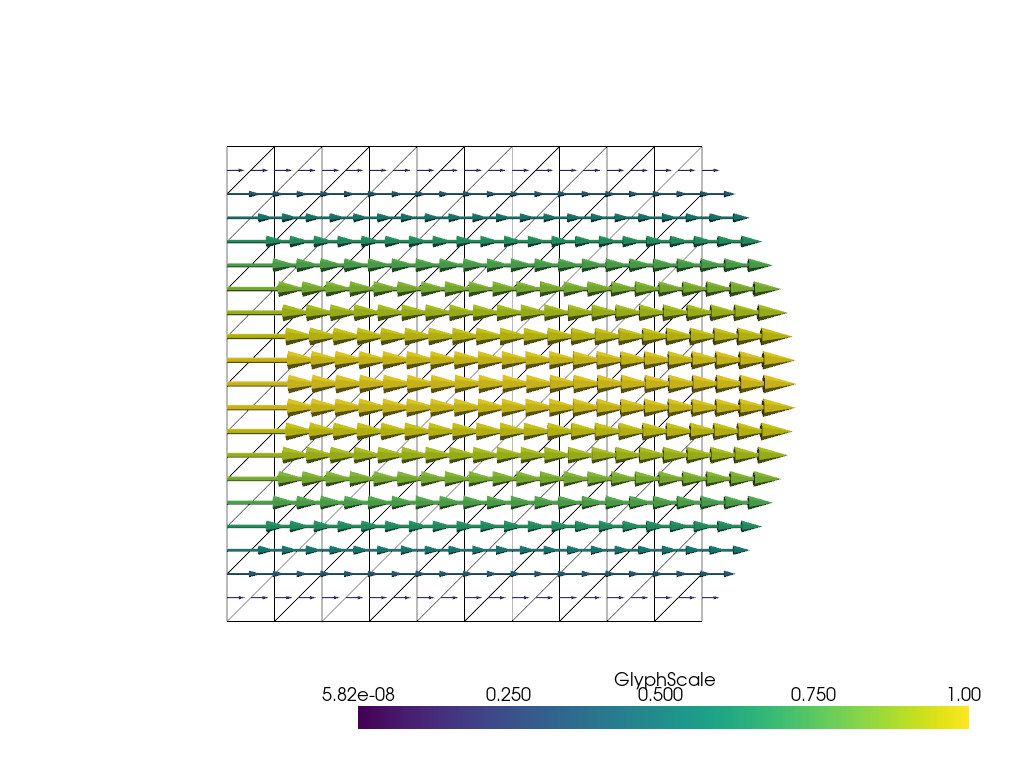

In [12]:
# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

Above is the velocity profile found from FEniCSx; it takes the expected parabolic shape.  

## External Body Force

Note how the flow changes when we add an external body force $f = -10$. This can be thought of as a gravity force.

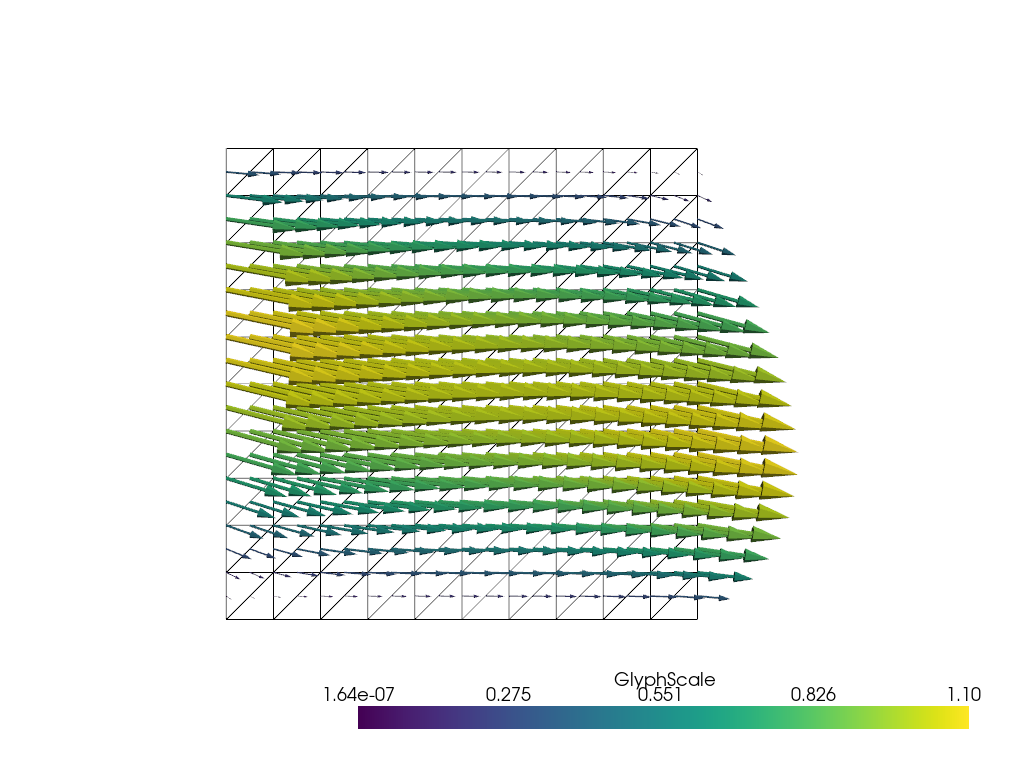

In [14]:
# *** ADD CONSTANT FORCE *** #

f = Constant(mesh, PETSc.ScalarType((0, -10))) # additional body forces (none here)

# ******** REDEFINE THE VARIATIONAL FORMS ***** #

# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  # velocity form last time
u_n.name = "u_n" # name the variable
U = 0.5 * (u_n + u) # velocity predictor (u^{n+1/2})

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) # pressure from last step 
p_n.name = "p_n" # name variable
F1 = rho * dot((u - u_n) / k, v) * dx # first term eq. 39
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx # second term eq.39
F1 += inner(sigma(U, p_n), epsilon(v)) * dx # third term eq. 39
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds # fourth term eq 39
F1 -= dot(f, v) * dx # fifth term eq. 39
a1 = form(lhs(F1)) # a1 = LHS of eq. 39
L1 = form(rhs(F1)) # L1 = rhs of eq. 39

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) # assemble matrix for lhs of 39, note boundary conditions
A1.assemble() # assemble step
b1 = create_vector(L1) # rhs of equation to be solved

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) # u_ = velocity prediction (u*)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) # LHS of eq 40
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) # rhs of eq 40
A2 = assemble_matrix(a2, bcs=bcp) # assemble matrix with BC
A2.assemble() # assemble
b2 = create_vector(L2) # make vector for rhs
# A2*p = b2

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) # p_ = p from step 2
a3 = form(rho * dot(u, v) * dx) # lhs of (42)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) # rhs of (42)
A3 = assemble_matrix(a3) # assemble
A3.assemble() # assemblt
b3 = create_vector(L3) # rhs vector
# A3 * U = b3


# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) # create solver
solver1.setOperators(A1) # set A1 as operator in equation
solver1.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme (nonsymmetric)
pc1 = solver1.getPC() # get preconditioner
pc1.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc1.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) # create solver
solver2.setOperators(A2) # set A2 as operator
solver2.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme
pc2 = solver2.getPC() # get preconditioner
pc2.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc2.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) # create solver
solver3.setOperators(A3) # set A3 as operator
solver3.setType(PETSc.KSP.Type.CG) # use conjugate gradient scheme
pc3 = solver3.getPC() # get preconditioner
pc3.setType(PETSc.PC.Type.SOR) # use Gauss Seidel preconditioner


# *** OUTPUT FILES *** #

from pathlib import Path # for navigation
folder = Path("results") # define output directory as pwd/results
folder.mkdir(exist_ok=True, parents=True) # make the output directory and any recursive directories
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u_gravity.bp", u_n, engine="BP4") # make vtx file for velocity 
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p_gravity.bp", p_n, engine="BP4") # make vtx file for pressure
vtx_u.write(t) # write time to velocity file
vtx_p.write(t) # write time to pressure file

# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # rhs of eq 39 is stored in b1 as a vector
    apply_lifting(b1, [a1], [bcu]) # apply BC to the coefficient matrix
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b1, bcu) # set BC on the rhs
    solver1.solve(b1, u_.x.petsc_vec) # solve A1 * u* = b1 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) # rhs of eq. 40 is stored in b2
    apply_lifting(b2, [a2], [bcp]) # apply BC to the coefficient matrix
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b2, bcp) # set the BC
    solver2.solve(b2, p_.x.petsc_vec) # solve A2*p = b2 based on set schemes
    p_.x.scatter_forward() # sync for parallel processing

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) # rhs of eq. 42 stored in b3
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    solver3.solve(b3, u_.x.petsc_vec) # solve A3 * u = b3 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

# Close xmdf files
vtx_u.close()
vtx_p.close()

# detroy the solvers and the vectors
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()


# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs_gravity.png")

The velocity is now pointed at a downward angle because of that additional external force. Intuitively, this velocity profile makes sense based on the direction of the force.